
# Inaugural Project


Cecilie Gøtterup-Hansen og Helene Thomsen, Hold 3

Import packages

In [1]:
#Import 
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        H = np.nan
        if par.sigma == 0:
            H = np.fmin(HM, HF)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**((1-par.rho)/(1-par.rho))

        # d. disutility of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]          

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve(self,do_print=False):
        """ solve model continously """
        
        opt = SimpleNamespace()

        # define objective function to maximize
        def objective(x):
            LM, HM, LF, HF = x
            return -self.calc_utility(LM, HM, LF, HF)

        # define constraints and bounds
        def constraints(x):
            LM, HM, LF, HF = x
            return [24 - LM - HM, 24 - LF - HF]
        
        constraints = ({'type':'ineq', 'fun': constraints})
        bounds = ((0,24),(0,24),(0,24),(0,24))

        # initial guess
        initial_guess = [6, 6, 6, 6]

        # call solver
        solution = optimize.minimize(
            objective, initial_guess, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
            )
        
        opt.LM, opt.HM, opt.LF, opt.HF = solution.x

        return opt
   

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """

        par = self.par
        sol = self.sol

        # fill out solution vectors for HF and HM
        for i, wF in enumerate(par.wF_vec):
            par.wF = wF
            optimum = self.solve()
            sol.HF_vec[i] = optimum.HF
            sol.HM_vec[i] = optimum.HM
            sol.LF_vec[i] = optimum.LF
            sol.LM_vec[i] = optimum.LM
        
        return sol.HF_vec, sol.HM_vec, sol.LF_vec, sol.LM_vec


    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol
        
        self.solve_wF_vec()

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T

        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]

        return sol.beta0,sol.beta1
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """
        
        par = self.par
        sol = self.sol

        # define objective function to minimize
        def objective(x):
            alpha, sigma = x
            par.alpha = alpha
            par.sigma = sigma
            self.solve_wF_vec()
            self.run_regression()
            return (par.beta0_target - sol.beta0)**2+(par.beta1_target - sol.beta1)**2
        
        # initial guess
        initial_guess = [0.5, 1.0]

        # call solver
        solution = optimize.minimize(objective, initial_guess, method='Nelder-Mead')

        alpha_min, sigma_min = solution.x

        return alpha_min, sigma_min 
    

### Question 1

To illustrate the ratio of HF and HM we define opt.HFM in the previous code under d. U

In [3]:
model1 = HouseholdSpecializationModelClass()

for alpha in np.linspace(0.25, 0.75, 3):
    model1.par.alpha = alpha
    for sigma in np.linspace(0.5, 1.5, 3):
        model1.par.sigma = sigma
        # call solve function and compute HF-HM-ratio
        optimum = model1.solve_discrete()
        ratio = optimum.HF/optimum.HM
        # print
        print(f'for alpha = {alpha:.2f} and sigma = {sigma:.2f} -> HF-HM-ratio = {ratio:.2f}')

C:\Users\cecil\AppData\Local\Temp\ipykernel_1900\637870707.py:54: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))


for alpha = 0.25 and sigma = 0.50 -> HF-HM-ratio = 0.60
for alpha = 0.25 and sigma = 1.00 -> HF-HM-ratio = 0.33
for alpha = 0.25 and sigma = 1.50 -> HF-HM-ratio = 0.20
for alpha = 0.50 and sigma = 0.50 -> HF-HM-ratio = 1.00
for alpha = 0.50 and sigma = 1.00 -> HF-HM-ratio = 1.00
for alpha = 0.50 and sigma = 1.50 -> HF-HM-ratio = 1.00
for alpha = 0.75 and sigma = 0.50 -> HF-HM-ratio = 1.67
for alpha = 0.75 and sigma = 1.00 -> HF-HM-ratio = 3.00
for alpha = 0.75 and sigma = 1.50 -> HF-HM-ratio = 5.00


### Question 2

In [11]:
model2 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio =[]

for wF in model2.par.wF_vec:
    model2.par.wF = wF
    optimum = model2.solve_discrete()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model2.par.wM)
    log_wratio = np.append(log_wratio, log_wF)


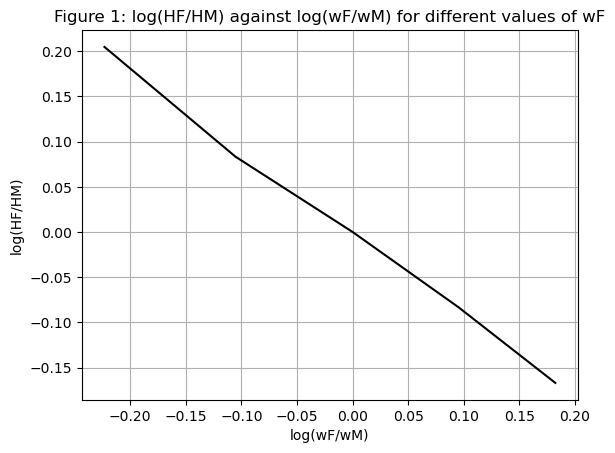

In [18]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, log_Hratio, color='black')
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Figure 1: log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

In [19]:
model3 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio =[]

for wF in model3.par.wF_vec:
    model3.par.wF = wF
    optimum = model3.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model3.par.wM)
    log_wratio = np.append(log_wratio, log_wF)


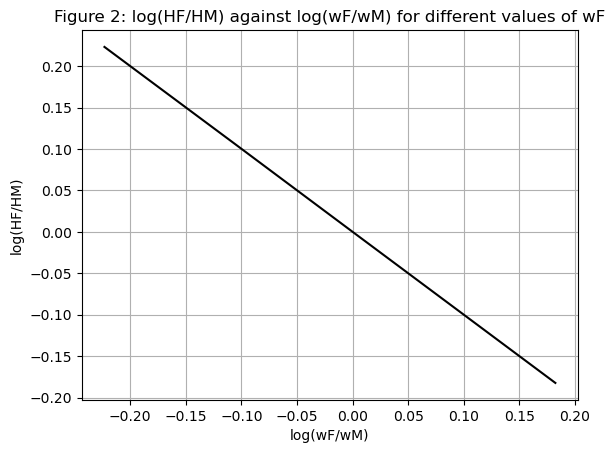

In [21]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, log_Hratio, color='black')
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Figure 2: log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

### Question 4

Using the function estimate(), we estimate the values of alpha and sigma which minimzes the squared distance between beta0 and beta0_target and the squared difference between beta1 and beta1_target.

C:\Users\cecil\AppData\Local\Temp\ipykernel_1900\637870707.py:167: RuntimeWarning: divide by zero encountered in divide
  y = np.log(sol.HF_vec/sol.HM_vec)
C:\Users\cecil\AppData\Local\Temp\ipykernel_1900\637870707.py:54: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))
C:\Users\cecil\AppData\Local\Temp\ipykernel_1900\637870707.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))


(alpha, sigma) = (0.9818859512537652, 0.10018275256179693)


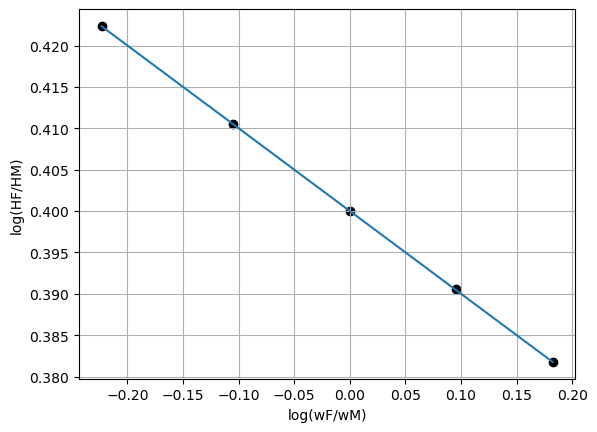

In [22]:
model4 = HouseholdSpecializationModelClass()
model4.estimate()
print(f'(alpha, sigma) = {model4.estimate()}')

# inkluder minimerende alpha og sigma

log_Hratio = []
log_wratio =[]

for wF in model4.par.wF_vec:
    model4.par.wF = wF
    optimum = model4.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model4.par.wM)
    log_wratio = np.append(log_wratio, log_wF)


# Siminski and Yetsenga's regression line
def f(log_wratio):
    return 0.4 +(-0.1)*log_wratio


# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
# plot Siminski and Yetsengaøs results as line
ax.plot(log_wratio, f(log_wratio))
# plot model's results as scatter dots
ax.scatter(log_wratio, log_Hratio, color='black')

 mangler legend#
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("")
plt.show()

